In [14]:
## Imports

import requests
import pandas as pd
from isbtchot.model import btc_historical_daily
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


In [15]:
## Create dataset

url = 'https://bitcoin-data.com/v1/realized-price'
headers = {
    'accept': 'application/hal+json',
}

response = requests.get(url, headers=headers)

# Convert the response to JSON
data = response.json()

# Create the DataFrame
df_realized = pd.DataFrame(data)
df_realized.rename(columns={'theDay': 'time', 'realizedPrice': 'realized_price'}, inplace=True)
df_realized.drop(["unixTs"], axis=1, inplace=True)
df_realized.realized_price = df_realized.realized_price.astype("float64")

# Convert 'time' to datetime format
df_realized['time'] = pd.to_datetime(df_realized['time'])

df_price = btc_historical_daily()[["close"]].rename({"close": "price"}, axis=1).reset_index()

df = pd.merge(left=df_realized, right=df_price, on="time")
df["delta"] = (df.price - df.realized_price) / df.realized_price

# Handle inf values in the 'delta' column by replacing them with NaN
df['delta'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
df = df.dropna()

# Set the time column as the index
df.set_index('time', inplace=True)

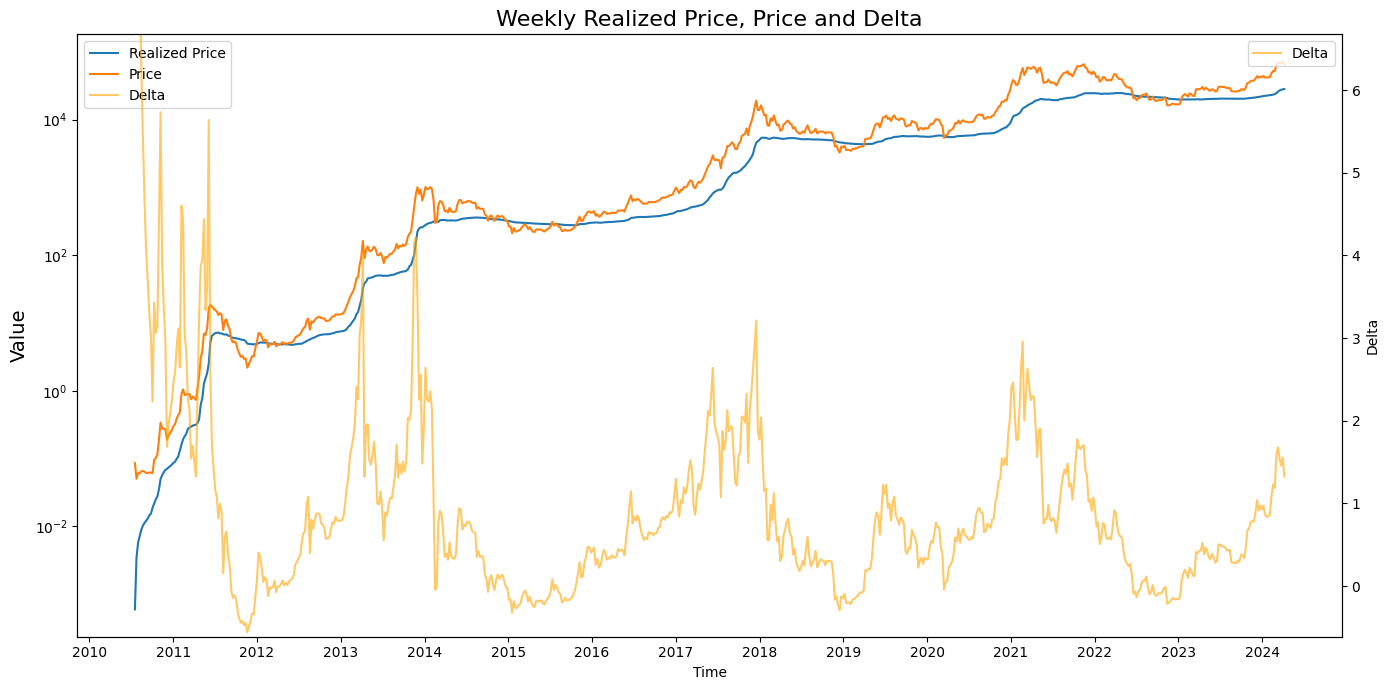

In [16]:
## Plot data

# Group by week and take the last value for that week
weekly_data = df.resample('W').last()

# Reset the index so that 'time' is a column again, which is necessary for Seaborn plots
weekly_data.reset_index(inplace=True)

# Initialize the matplotlib figure and primary y-axis
f, ax1 = plt.subplots(figsize=(14, 7))

# Plot the realized_price and price on the primary y-axis
sns.lineplot(x='time', y='realized_price', data=weekly_data, ax=ax1, label='Realized Price')
sns.lineplot(x='time', y='price', data=weekly_data, ax=ax1, label='Price')

# Set the primary y-axis to a logarithmic scale
ax1.set_yscale("log")

# Create a secondary y-axis for delta values
ax2 = ax1.twinx()

# Plot delta on the secondary y-axis, adjust the width of the bars to make the plot less cluttered
sns.lineplot(x='time', y='delta', data=weekly_data, ax=ax2, color='orange', label='Delta', alpha=0.6)

# Set the secondary y-axis label
ax2.set_ylabel('Delta')

# Possibly adjust the limits of the secondary y-axis if delta values are too small
ax2.set_ylim(weekly_data['delta'].min()*1.1, weekly_data['delta'].mean() * 6)

# Set the axis labels and title
ax1.set_xlabel('Time')
ax1.set_ylabel('Value', fontsize=14)
ax1.set_title('Weekly Realized Price, Price and Delta', fontsize=16)

# Configure date formatting on x-axis
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Improve the legend to show labels for both y-axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show the plot with a tight layout to ensure no clipping occurs
plt.tight_layout()
plt.show()


In [17]:
## Expected top at current realized price
int(weekly_data.tail(1)["realized_price"].iloc[0] * 3)

84529